In [4]:
import os
import json
import pickle
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

from tqdm.auto import tqdm


# === ARC 색상 매핑 ===
arc_colors = ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
              '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25']
cmap = ListedColormap(arc_colors)
norm = BoundaryNorm(range(11), cmap.N)

In [10]:
# === ARC 데이터셋 클래스 ===
class ARCDataset:
    def __init__(self, base='../arc-prize-2025'):
        path = Path(base)
        self.data = {
            k: self._load(path / f) for k, f in {
                'train_ch': 'arc-agi_training_challenges.json',
                'train_sol': 'arc-agi_training_solutions.json',
                'eval_ch': 'arc-agi_evaluation_challenges.json',
                'eval_sol': 'arc-agi_evaluation_solutions.json'
            }.items()
        }

    def _load(self, file):
        return json.load(open(file)) if file.exists() else {}

    def get_split(self, split='train'):
        if split == 'train':
            return self.data['train_ch'], self.data['train_sol']
        elif split == 'eval':
            return self.data['eval_ch'], self.data['eval_sol']
        else:
            raise ValueError("Invalid split")


# === 결과 로딩 ===
def load_predictions(pkl_path):
    with open(pkl_path, 'rb') as f:
        return pickle.load(f)


# === 단일 이미지 시각화 ===
def plot_one(ax, mat, title=""):
    ax.imshow(mat, cmap=cmap, norm=norm)
    ax.set_title(title, fontsize=8)
    ax.axis('off')


def visualize_prediction_comparison(task_id, test_input, prediction, solution, match, reason, save_path=None):
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    plot_one(axs[0], test_input, "Input")
    plot_one(axs[1], prediction, f"Prediction ({'Correct' if match else 'Wrong'})")
    plot_one(axs[2], solution, "Solution")

    # fig.suptitle(f"Task: {task_id}\nReason: {reason}", fontsize=9)
    fig.suptitle(f"Task: {task_id}", fontsize=9)
    fig.tight_layout(rect=[0, 0, 1, 0.88])

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, format="png")
        plt.close(fig)
    else:
        plt.show()
        plt.close(fig)


# === 전체 시각화 반복 ===
def visualize_all_predictions(predictions, challenges, output_dir=None, filter_fn=None):
    for task_id, results in tqdm(predictions.items()):
        task = challenges.get(task_id)
        if task is None:
            continue

        test_inputs = [d['input'] for d in task.get("test", [])]
        if len(test_inputs) != len(results):
            print(f"⚠️ Skipping {task_id}: mismatch between test and prediction length")
            continue

        for idx, (input_mat, result) in enumerate(zip(test_inputs, results)):
            if filter_fn and not filter_fn(result):
                continue

            pred = result.get("prediction")
            sol = result.get("solution")
            match = result.get("match", False)
            reason = result.get("reason", "")

            if pred is None or sol is None:
                continue

            filename = f"{task_id}_test{idx}.png" if output_dir else None
            save_path = os.path.join(output_dir, filename) if output_dir else None

            visualize_prediction_comparison(task_id, input_mat, pred, sol, match, reason, save_path)


  0%|          | 0/16 [00:00<?, ?it/s]

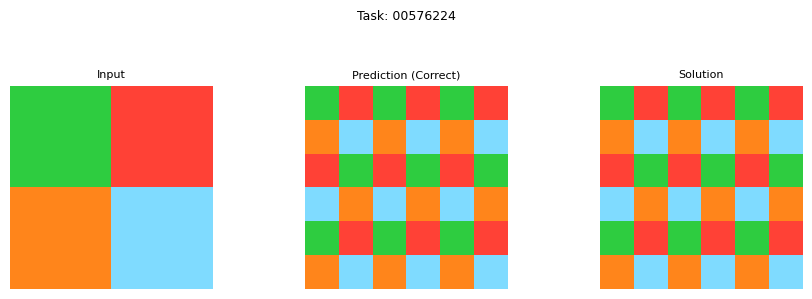

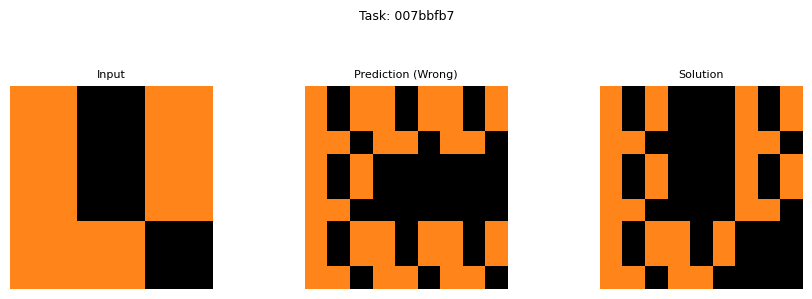

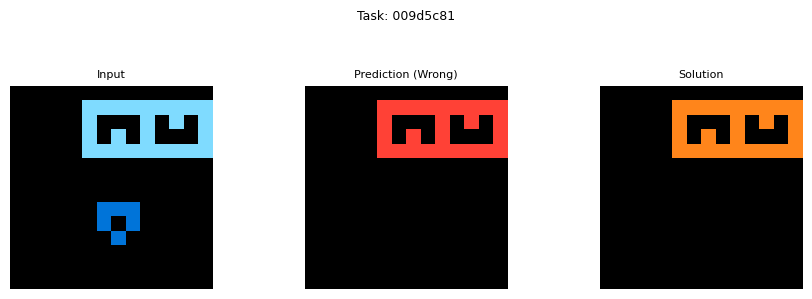

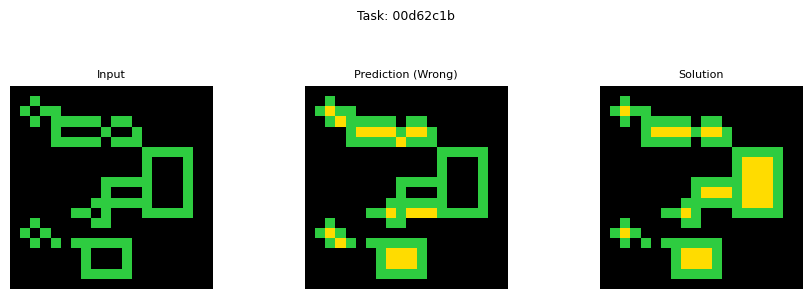

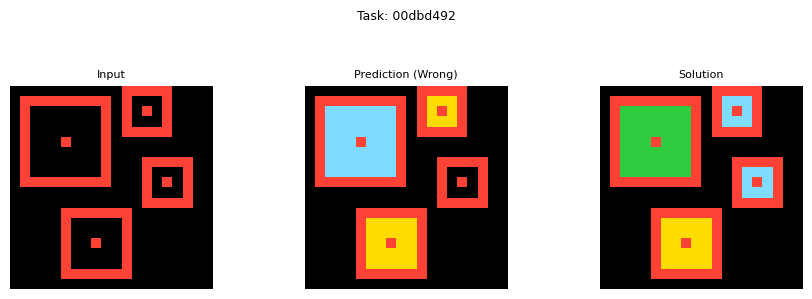

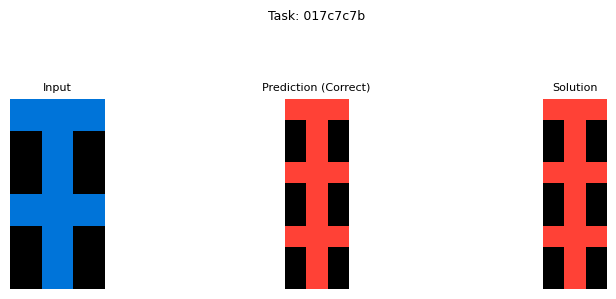

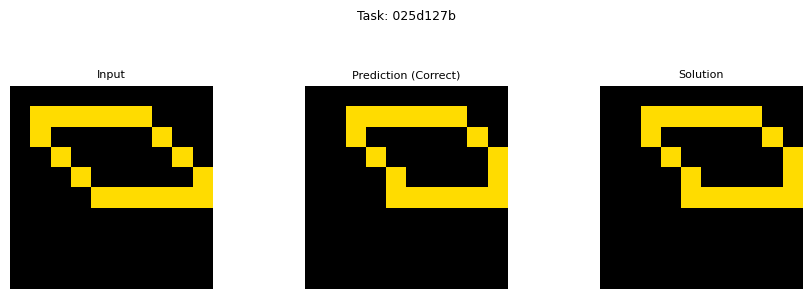

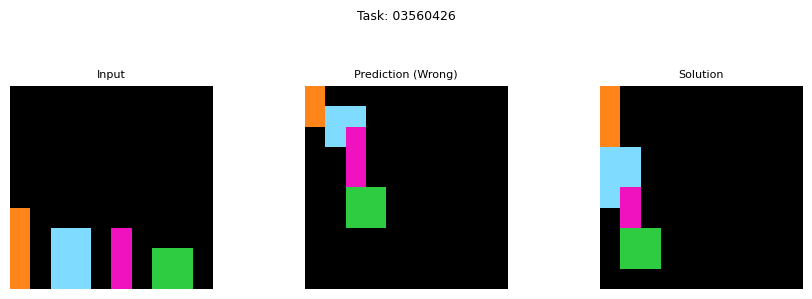

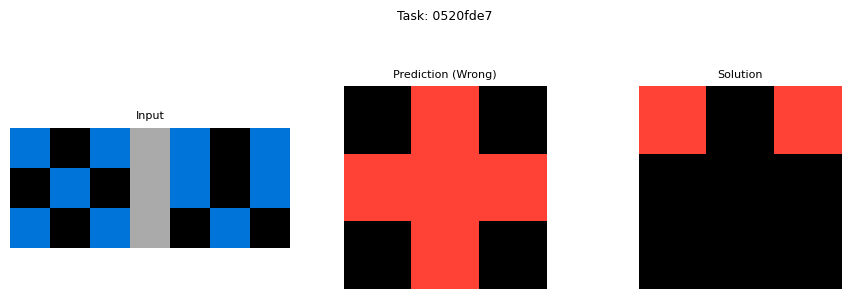

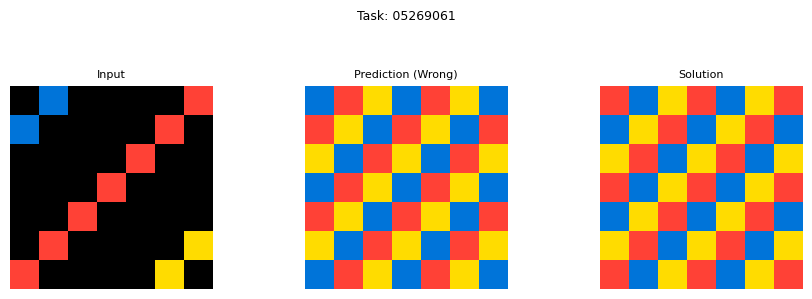

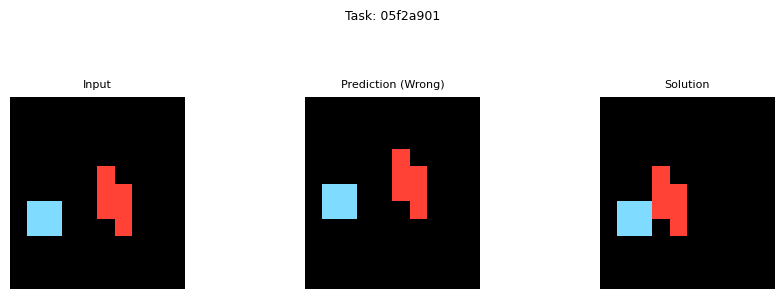

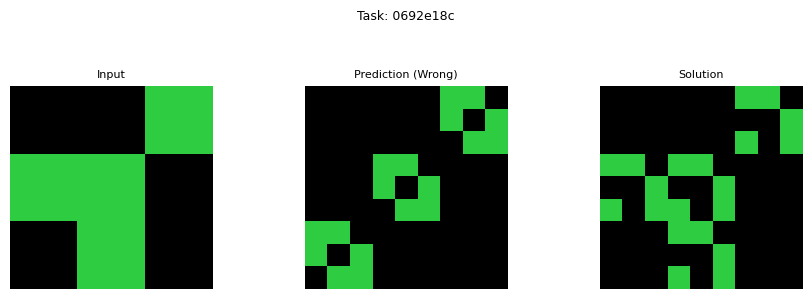

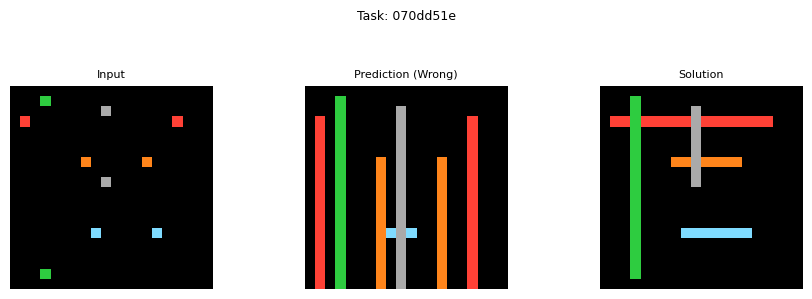

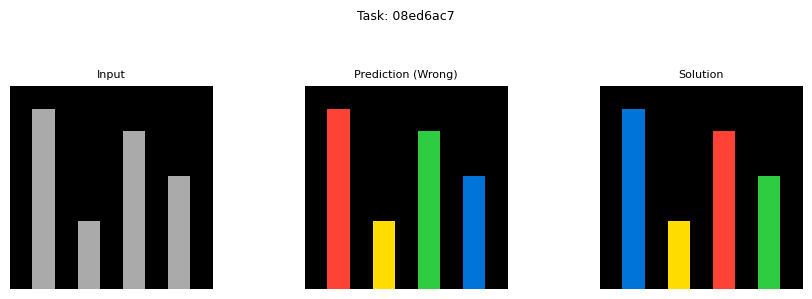

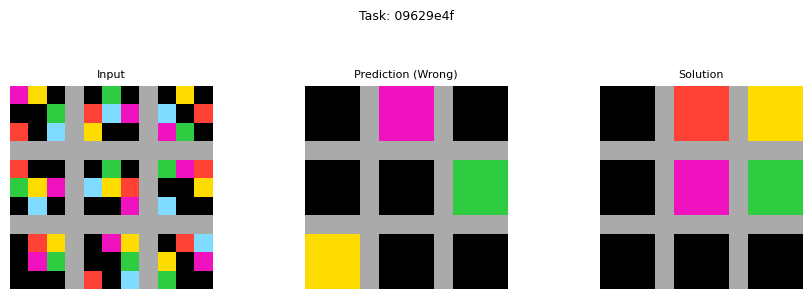

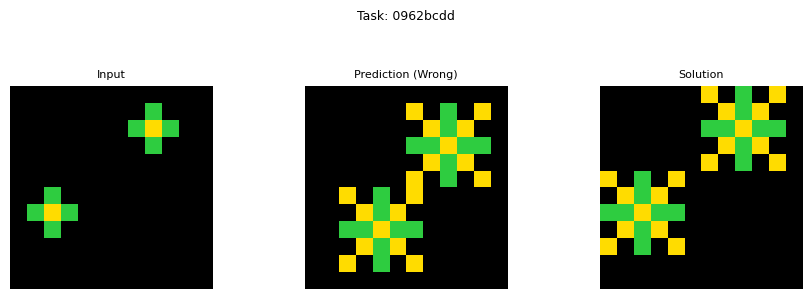

  0%|          | 0/16 [00:00<?, ?it/s]

In [11]:
ds = ARCDataset()
train_challenges, _ = ds.get_split('train')

# 예측 결과 불러오기
preds = load_predictions("chatgpt_predictions.pkl")

# 전체 시각화: 화면 출력
visualize_all_predictions(preds, train_challenges)

# 실패한 케이스만 PNG 저장
visualize_all_predictions(
    preds,
    train_challenges,
    output_dir="predictions",
    filter_fn=lambda r: not r["match"]
)